In [ ]:
#Gradient Boost trained with basic data, with data augmentation SAME for each label and using labels-v4

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import os
import time

In [2]:
# nombre de instancia
# número restricciones
# número variables
# timestep
# solver (label)

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path=main_path+"datasets-v4/"

columns = ["# variables","# constraints","timestep","solver"]
names=[]
num_var=[]
num_rest=[]
timestep=[]
solvers=[]

#Recolectar data de txt files
with open(d_path+"txt_files/inst_info.txt") as f:
    lines = f.readlines()
    for l in lines:
        words=l.split()
        for n in range(0,500): #repetir 500 cada instancia, para que cuadre con los timesteps
            names.append(words[0])
            num_var.append(int(words[2]))
            num_rest.append(int(words[3]))
            timestep.append(n)
        
with open(main_path+"labels-v4.txt") as f:
    lines = f.readlines()
    for l in lines:
        for word in l.split():
            solvers.append(int(word))

In [3]:
#Crear dataframe
# dataframe with no names, so that it doesn't convert everything to str 
data=np.array([num_var,num_rest,timestep,solvers])
df = pd.DataFrame(data.T, columns=columns)
            
#print(df.head())

In [4]:
x=df[['# variables','# constraints','timestep']]
y=df[['solver']]

#agrupar diferentes timestpes de cada instancia en un mismo set
random.seed(9) #same seed to generate same random numbers as other models
train_indx=[]
inst_train=[]
test_indx=[]
for i in range(0,3128): # v4
    r = random.randint(0,2)
    if(r==2):
        for j in range(0,500):
            test_indx.append(500*i+j)
    else:
        inst_train.append(i)
        for j in range(0,500):
            train_indx.append(500*i+j)

x_train=x.iloc[train_indx]
x_test=x.iloc[test_indx]
y_train=y.iloc[train_indx]
y_test=y.iloc[test_indx]
y_train_og=y.iloc[train_indx]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1027000, 3)
(537000, 3)
(1027000, 1)
(537000, 1)


In [5]:
#Data augmentation para training set de instancias con clases distintas a gurobi (5)

indx_dis=[] #indexes of instances with disadvantaged labels 

#identificar instancias que tengan clase distinta a gurobi
for i in inst_train:
    has_dis=False
    for j in range(500):
        ind=500*i+j
        if(solvers[ind]!=5):
            has_dis=True
            break
    if(has_dis):
        for j in range(500):
            indx_dis.append(500*i+j)

print(len(indx_dis))
print(len(train_indx), end="\n\n")            

#agregar las instancias al final de x_train e y_train
x_train_dis=x.iloc[indx_dis]
y_train_dis=y.iloc[indx_dis]

x_train=x_train.append(x_train_dis)
y_train=y_train.append(y_train_dis)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

674500
1027000

(1701500, 3)
(537000, 3)
(1701500, 1)
(537000, 1)


In [6]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, max_features="sqrt", random_state=0)
gbc_model.fit(np.nan_to_num(x_train.astype(np.float32)), y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
y_pred = gbc_model.predict(np.nan_to_num(x_test.astype(np.float32)))

In [8]:
print("Accuracy",metrics.accuracy_score(y_test.values.ravel(), y_pred))
pred = gbc_model.predict_proba(np.nan_to_num(x_test.astype(np.float32)))
print("Loss",metrics.log_loss(y_test.values.ravel(), pred))

Accuracy 0.6379217877094973
Loss 1.44590080389686


In [9]:
#Save
l=int(len(y_test)/500)
y_test_np=y_test.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_basic-v4/results/y_test.txt", "w")
np.savetxt(f,y_test_np.reshape(y_test_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_pred)/500)
y_pred_np=y_pred.reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_basic-v4/results/y_preds.txt", "w")
np.savetxt(f,y_pred_np.reshape(y_pred_np.shape[0],-1),fmt='%s')
f.close()

#print(y_pred_np.shape)
#print(y_pred_np)

In [10]:
l=int(len(y_train)/500)
y_train_np=y_train.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_basic-v4/results/y_train.txt", "w")
np.savetxt(f,y_train_np.reshape(y_train_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_train_og)/500)
y_train_og_np=y_train_og.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_basic-v4/results/y_train_og.txt", "w")
np.savetxt(f,y_train_og_np.reshape(y_train_og_np.shape[0], -1),fmt="%s")
f.close()

In [11]:
#Feature importances
importances = gbc_model.feature_importances_
feats = x.columns

f=open(main_path+"models/v4/gradientBoost_basic-v4/results/features_and_acc.txt", "w")

i=0
while i < len(feats):
    print("Importance of feature "+feats[i]+" is "+str(importances[i]))
    f.write("Importance of feature "+feats[i]+" is "+str(importances[i]))
    i = i+1

print(metrics.accuracy_score(y_test.values.ravel(), y_pred))
f.write("Testing accuracy: "+str(metrics.accuracy_score(y_test.values.ravel(), y_pred)))

f.close()

Importance of feature # variables is 0.475607237470795
Importance of feature # constraints is 0.4805763976444234
Importance of feature timestep is 0.04381636488478169
0.6379217877094973


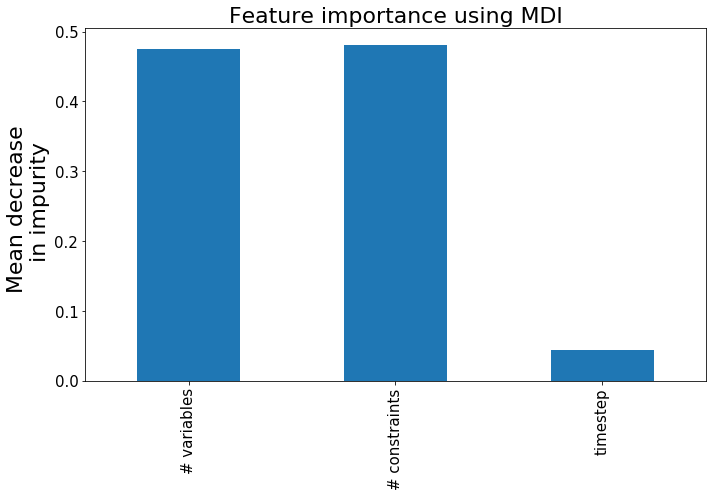

In [13]:
#Grafico feature importances
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

forest_importances = pd.Series(importances, index=feats)

fsize = 22

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, figsize = (10,7), fontsize=fsize-7)
plt.xticks(rotation=90, fontsize=fsize-7)
ax.set_title("Feature importance using MDI", fontsize=fsize)
ax.set_ylabel("Mean decrease \n in impurity", fontsize=fsize)
fig.tight_layout()

#print(importances)

https://www.tutorialspoint.com/scikit_learn/scikit_learn_boosting_methods.htm#

https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/

https://towardsdatascience.com/gradient-boosting-classification-explained-through-python-60cc980eeb3d

# Prediction Times

In [9]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

l=int(len(y_pred)/500)
t_preds=np.empty(l*500)
i=0

#prediccion
for idx in test_indx:
    #crear dataframe de solo esa instancia-timestep
    x_i = x.iloc[[idx]]
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = gbc_model.predict(np.nan_to_num(x_i.astype(np.float32)))
    tiempo=time.time()-start
    t_preds[i]=tiempo
    
    i=i+1

In [10]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_gradientBoost_basic-v4.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.00155258 0.00121474 0.00096416 ... 0.00078249 0.00077868 0.00078058]
